In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from copy import copy

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Model

In [2]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "lazyload"
env_name = "tree_layers7_bprob0.9_envs600000_H800_explore"
#model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0.1_batch256"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
path_to_pkl = os.path.join(model_path, ckpt_name)

In [3]:
# Extract parameters using regex
import re
n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))


model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [4]:
from src.models.transformer_end_query import Transformer
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


/tmp/ipykernel_2910745/3170755486.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [6]:
eval_dataset_path = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/datasets/tree_layers7_bprob1.0_envs600000_H1600_explore/eval.h5"
eval_trajs = h5py.File(eval_dataset_path, 'r')
traj_indices = list(eval_trajs.keys())
n_eval_envs = min(50, len(traj_indices))
random.seed(0)
traj_indices = random.sample(traj_indices, n_eval_envs)
random.seed()
eval_trajs = [eval_trajs[i] for i in traj_indices]


In [27]:
def run_model(traj, model, state_features, seq_length):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer].cpu().numpy().squeeze()[-1])
    return hidden_states

In [76]:
def get_node_and_representation(traj, env, model):
    nodes = []
    hidden_states = []
    seq_lengths = []
    state_features = []
    state_features = list(env.node_map.keys())

    _nodes = [] 
    for state_feature in state_features:
        _nodes.append(str(env.node_map[state_feature]))
    for seq_length in [1, 25, 50, 75, 100, 250, 500, 750, 1000]:
        _hidden_states = run_model(traj, model, state_features, seq_length=seq_length)
        for l in range(model.n_layer):
            if len(_hidden_states[l]) != len(_nodes):
                print(l)
                print(len(_hidden_states[l]), len(_nodes))
                import pdb; pdb.set_trace()
        nodes.append(_nodes)
        hidden_states.append(_hidden_states)
        seq_lengths.append(seq_length)

    return nodes, hidden_states, seq_lengths

In [79]:
results = {
    'nodes': [],
    'hidden_states': [],
    'model_layer': [], 
    'context_length': []
}

for i_eval, traj in enumerate(eval_trajs[:10]):
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding': 'random',
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalTrees().create_env(env_config, np.array(traj['goal']), i_eval)
    nodes, hidden_states, context_lengths = get_node_and_representation(traj, env, model)
    for _nodes, _hidden_states, _context_length in zip(nodes, hidden_states, context_lengths):
        for i_layer, model_layer_hidden_states in enumerate(_hidden_states):
            results['nodes'].extend(_nodes)
            results['hidden_states'].extend(model_layer_hidden_states)
            results['model_layer'].extend([i_layer] * len(_nodes))
            results['context_length'].extend([_context_length] * len(_nodes))

In [80]:
for k in results.keys():
    print(k, len(results[k]))

nodes 34290
hidden_states 34290
model_layer 34290
context_length 34290


In [81]:
df = pd.DataFrame(results)

In [82]:
same_node = {
    'sim': [],
    'model_layer': [],
    'context_length': []
}
diff_node = {
    'sim': [],
    'model_layer': [],
    'context_length': []
}

for context_length in df['context_length'].unique():
    context_length_df = df[df['context_length'] == context_length]
    for i_layer in context_length_df['model_layer'].unique():
        layer_df = context_length_df[context_length_df['model_layer'] == i_layer]
        for node in layer_df['nodes'].unique():
            node_df = layer_df[layer_df['nodes'] == node]
            other_node_df = layer_df[layer_df['nodes'] != node]
            node_hidden_states = np.stack(node_df['hidden_states'].to_numpy())
            other_node_hidden_states = np.stack(other_node_df['hidden_states'].to_numpy())
            n_same_node = node_hidden_states.shape[0]
            stacked_reprs = np.vstack((node_hidden_states, other_node_hidden_states))
            cc = np.corrcoef(stacked_reprs)
            for i in range(n_same_node):
                for j in range(i+1, n_same_node):
                    same_node['sim'].append(cc[i, j])
                    same_node['model_layer'].append(i_layer)
                    same_node['context_length'].append(context_length)
            for i in range(n_same_node):
                for j in range(n_same_node, stacked_reprs.shape[0]):
                    diff_node['sim'].append(cc[i, j])
                    diff_node['model_layer'].append(i_layer)
                    diff_node['context_length'].append(context_length)

In [83]:
same_node_df = pd.DataFrame(same_node)
diff_node_df = pd.DataFrame(diff_node)


In [95]:
ax.patches[0].get_facecolor()


(0.09068627450980393, 0.42598039215686273, 0.6112745098039215, 1)

In [98]:
ax.patches[3].get_facecolor()

(0.7642156862745098, 0.5318627450980391, 0.12598039215686285, 1)

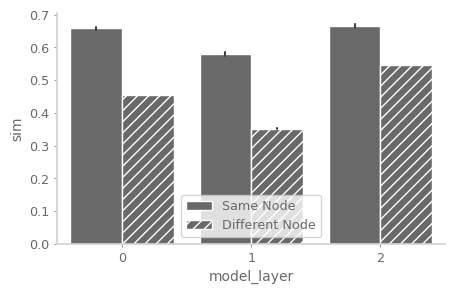

In [103]:
_same_node_df = same_node_df[same_node_df['context_length'] == 1000]
_diff_node_df = diff_node_df[diff_node_df['context_length'] == 1000]
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.barplot(
    data=pd.concat([
        _same_node_df.assign(type='Same Node'),
        _diff_node_df.assign(type='Different Node')
    ]),
    x='model_layer', y='sim', hue='type', ax=ax, 
    )

for i, bar in enumerate(ax.patches):
    if bar.get_facecolor() == (0.7642156862745098, 0.5318627450980391, 0.12598039215686285, 1):  # C1 color
        bar.set_hatch('///')
    bar.set_facecolor('dimgray')
plt.legend()
plt.show()



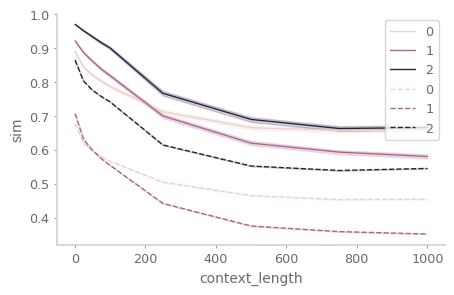

In [85]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=same_node_df, x='context_length', y='sim', hue='model_layer', ax=ax)
sns.lineplot(data=diff_node_df, x='context_length', y='sim', hue='model_layer', ax=ax, linestyle='--')
plt.legend()
plt.show()

